# Rakshit Sareen : rs5606@nyu.edu

In [2]:
import os
import cv2
import numpy as np
import sys
import math
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
bwimage = "./five.jpeg"
bwimg = cv2.imread(bwimage,0)

### The Original Image

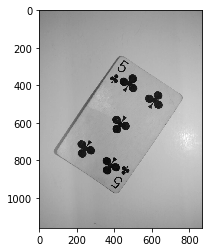

In [4]:
plt.imshow(bwimg,cmap='gray')

# Convolution

###### The code below is about convolution. It takes and image, kernel and the kernelsize as three parameters and applies convolution over the image.

In [5]:
def convolve2d(image, kernel, kernelsize):
    """
    This function assumes square kernels for now.
    """
    assert kernelsize%2 == 1 #this step is important
    kernel = np.flipud(np.fliplr(kernel))
    output = np.zeros_like(image)
    image_padded = np.zeros((image.shape[0] + kernelsize - 1, image.shape[1] + kernelsize - 1))
    skipfactor = (kernelsize-1)/2
    image_padded[skipfactor:-skipfactor, skipfactor:-skipfactor] = image
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            output[x,y]=(kernel*image_padded[x:x+kernelsize,y:y+kernelsize]).sum()
    return output

#### Convolution with 5X5 normalised kernel

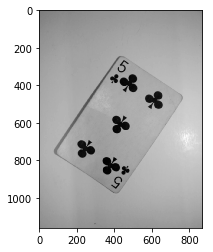

In [6]:
kernel5X5 = np.ones((5,5),np.float32)/25
output = convolve2d(bwimg,kernel5X5,5)
plt.imshow(output,cmap='gray')

### Convolution with 3X3 normalised kernel

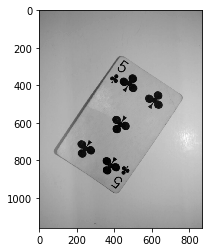

In [7]:
kernel3X3 = np.ones((3,3),np.float32)/9
output = convolve2d(bwimg,kernel3X3,3)
plt.imshow(output,cmap='gray')

### Convolution with 13 X 13 normalised kernel

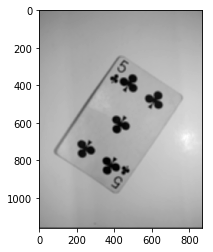

In [8]:
kernel13X13 = np.ones((13,13),np.float32)/169
output = convolve2d(bwimg,kernel13X13,13)
plt.imshow(output,cmap='gray')

# Edge Detection

### This code creates derivative matrices in the x and y direction and convolves with the original image

In [9]:
yderiv = np.array([[-0.5,0,0.5],[-0.5,0,0.5],[-0.5,0,0.5]])
xderiv = np.array([[-0.5,-0.5,-0.5],[0,0,0],[0.5,0.5,0.5]])

#### We need to smooth the image using the convolution technique above 

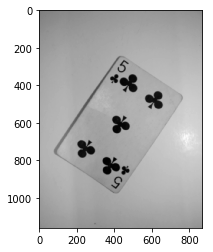

In [10]:
kernel = np.ones((41,41),np.float32)/1681
#smoothimg = convolve2d(bwimg,kernel,41)
smoothimg = cv2.GaussianBlur(bwimg,(13,13),0)
plt.imshow(smoothimg,cmap='gray')


### Now this image is convolved with the y derivative matrix to get the y derivtive of the image

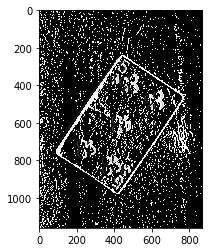

In [11]:
output = convolve2d(smoothimg,yderiv,3)
plt.imshow(output,cmap='gray')
iy = np.copy(output)

### Now this image is convolved with the x derivative matrix to get the x derivtive of the image

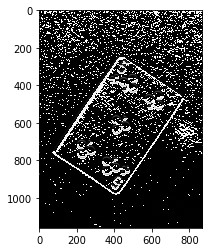

In [12]:
output = convolve2d(smoothimg,xderiv,3)
plt.imshow(output,cmap='gray')
ix = np.copy(output)

In [13]:
def nonMaximumSeparation(accumulator):
    indices = []
    output = np.zeros_like(accumulator)
    for i in range(1,accumulator.shape[0]-1):
        for j in range(1,accumulator.shape[1]-1):
            # if i am maximum in neighborhood, keep me, else make me 0
            me, up , down , left , right = accumulator[i][j] ,accumulator[i-1][j] \
            , accumulator[i+1][j] , accumulator[i][j-1], accumulator[i][j+1]
            upleft, upright, bottomleft, bottomright = accumulator[i-1][j-1] \
            , accumulator[i-1][j+1],accumulator[i+1][j-1],accumulator[i+1][j+1]
            #print up,down,left,right
            if me >= up and me >= down and me>=left and me>=right and me >=upleft and me>=upright \
            and me>=bottomleft and me>=bottomright:
                continue
                #output[i][j] = me
            else:
                indices.append((i,j))
                #output[i][j] = 0
    for point in indices:
        accumulator[point[0]][point[1]] = 0
    return accumulator

In [14]:
#dx = nonMaximumSeparation(ix)
#plt.imshow(dx,cmap='gray')

In [15]:
#dy = nonMaximumSeparation(iy)
#plt.imshow(dy,cmap='gray')

## Edge Map Calculation

#### The function below provides the calcuation of the edge map of an image. It takes the x and y derivative of the image and applies the formula sqrt(np.square(xderiv) + np.square(yderiv)) for every pixel in both the images.

In [16]:
# Calculation of Edge Map
def calculateEdgeMap(xderiv,yderiv):
    assert xderiv.shape == yderiv.shape
    output = np.zeros_like(xderiv)
    output = np.sqrt(np.square(xderiv) + np.square(yderiv))
    return output

In [17]:
edgemap = calculateEdgeMap(ix,iy)

#### This is normalizing of the values and converting the values as integer

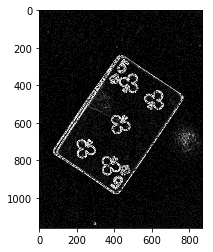

In [18]:
edgemap = (edgemap / np.max(edgemap)) * 255
edgemap = edgemap.astype(int) # this is an important step
plt.imshow(edgemap,cmap='gray')

### Calculation of the orientation map of the image

#### The function below provides the calcuation of the edge map of an image. It takes the x and y derivative of the image and applies the formula arctan2(iy,ix) for every pixel in both the images and return the resulting image.

In [19]:
# Orientation map : Calculating the arctan 
def calculateArctan(ix,iy):
    assert ix.shape == iy.shape
    output = np.zeros_like(edgemap)
    output = np.arctan2(iy,ix)
    return output

In [20]:
orientationmap = calculateArctan(ix,iy)

#### Scaling of the orientation map and converting them into integer values

In [21]:
orientationmap = (orientationmap / np.max(orientationmap)) * 360
orientationmap = orientationmap.astype(int)

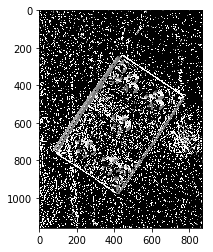

In [22]:
plt.imshow(orientationmap,cmap='gray')
plt.show()

In [23]:
#orientationmapx = nonMaximumSeparation(orientationmap)
#plt.imshow(orientationmapx,cmap='gray')

In [24]:
def calculateHistogram(img):
    histogram = np.zeros(361)
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            histogram[img[i,j]] += 1
    return histogram

[]

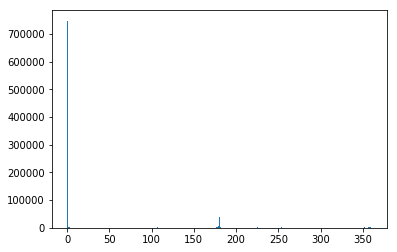

In [25]:
new_histogram = calculateHistogram(orientationmap)
y = plt.hist(range(0,new_histogram.shape[0]),weights = new_histogram, bins = 360)
plt.plot()

In [26]:
def thresholding(histogram):
    output = np.zeros_like(histogram)
    for i in range(histogram.shape[0]):
        if histogram[i] >= 50000:
            output[i] = histogram[i]
    return output

In [27]:
def thresholding(image, threshold):
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] < threshold :
                output[i][j] = 0
            else :
                output[i][j] = 255 #image[i][j]
    return output

In [28]:
thist = thresholding(new_histogram)
y = plt.hist(range(0,thist.shape[0]),weights = thist, bins = 360)
plt.plot()

TypeError: thresholding() takes exactly 2 arguments (1 given)

In [29]:
def returnpeaks(histogram):
    peaks = []
    th = thresholding(histogram)
    for i in range(th.shape[0]):
        if thist[i] != 0:
            peaks.append(i)
    return peaks

In [30]:
peaks = returnpeaks(new_histogram)
peaks

TypeError: thresholding() takes exactly 2 arguments (1 given)

In [31]:
peaks = [x for x in peaks if x != 0]
peaks

NameError: name 'peaks' is not defined

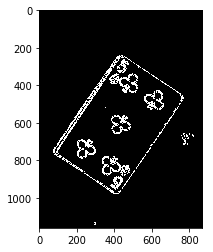

In [32]:
edgemap_t = thresholding(edgemap,100)
plt.imshow(edgemap_t,cmap='gray')

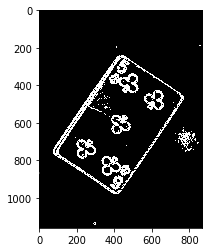

In [33]:
_edgemap_t = thresholding(edgemap,50)
plt.imshow(_edgemap_t,cmap='gray')

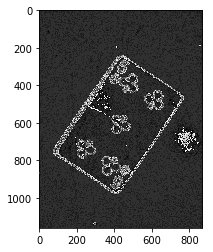

In [34]:
newimage = (_edgemap_t - edgemap)
plt.imshow(newimage,cmap='gray')

In [35]:
def houghTransform(image):
    diag = math.sqrt(math.pow(image.shape[0],2) + math.pow(image.shape[1],2))
    diag = int(diag)
    accumulator = np.zeros((diag,180))
    rho = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] != 0:
                for theta in range(0,180):
                    rho = int(i * math.cos(math.radians(theta)) + j* math.sin(math.radians(theta)))
                    accumulator[rho][theta] = accumulator[rho][theta] + 1
    return accumulator

In [36]:
acc = houghTransform(edgemap_t)

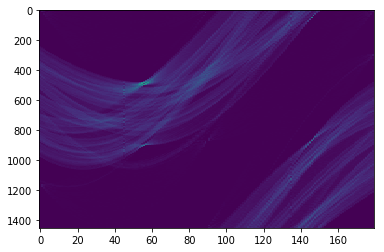

In [37]:
plt.imshow(acc,aspect='auto')

In [38]:
def findPeaksIndices(accumulator):
    output = []
    for i in range(accumulator.shape[0]):
        for j in range(accumulator.shape[1]):
            if accumulator[i][j] != 0 :
                output.append((i,j))
    return output

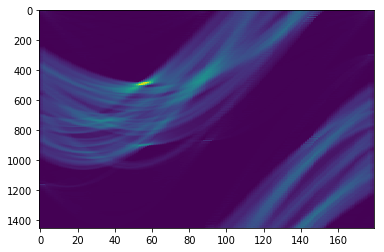

In [39]:
acck = np.ones((5,5),np.float32)/25
smoothed_acc = convolve2d(acc, acck, 5)
plt.imshow(smoothed_acc,aspect='auto')

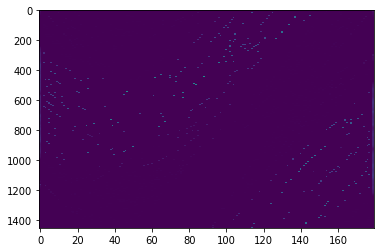

In [40]:
edgyacc = nonMaximumSeparation(smoothed_acc)
plt.imshow(edgyacc,aspect='auto')

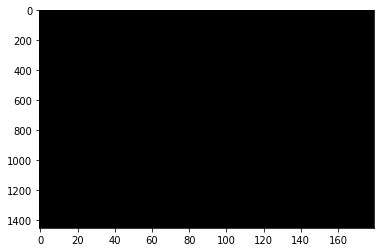

In [41]:
threshold_acc = thresholding(edgyacc,230)
plt.imshow(threshold_acc,aspect='auto',cmap='gray')

In [42]:
peaklist = findPeaksIndices(threshold_acc)
print peaklist

[(483, 57), (493, 55), (496, 54), (517, 51), (898, 55)]


In [43]:
def houghLines(peaklist,image):
    for point in peaklist:
        rho = point[0]
        theta = point[1]
        sintheta = math.sin(math.radians(theta))
        costheta = math.cos(math.radians(theta))
        if theta != 0:
            y1 = int(rho/sintheta)
            y2 = int((rho - image.shape[0]*costheta)/sintheta)
            cv2.line(image,(y1,0),(y2,image.shape[0]),(255,0,0),4)

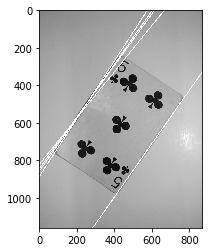

In [44]:
test_hough_image = cv2.imread('./five.jpeg',0)
houghLines(peaklist,test_hough_image)
plt.imshow(test_hough_image,cmap='gray')

In [99]:
thetas = [peaklist[i][1] for i in range(len(peaklist)) if peaklist[i][1] <= 90]

In [100]:
avg_angle = 90 - np.mean(thetas)
avg_angle

35.600000000000001

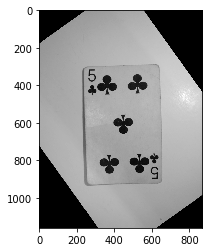

In [101]:
image = cv2.imread('./five.jpeg',0)
rows,cols = img.shape
M = cv2.getRotationMatrix2D((cols/2,rows/2),avg_angle,1)
dst = cv2.warpAffine(img,M,(cols,rows))
plt.imshow(dst,cmap='gray')

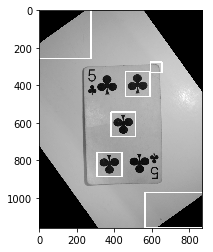

In [109]:
#gray = cv2.cvtColor(dst,cv2.COLOR_BGR2GRAY) # grayscale
_,thresh = cv2.threshold(dst,150,255,cv2.THRESH_BINARY_INV) 
#threshold
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
dilated = cv2.dilate(thresh,kernel,iterations = 13) # dilate
contours, hierarchy,z = cv2.findContours(dilated,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) 
# get contours
# for each contour found, draw a rectangle around it on original image
for contour in contours:
 
    # get rectangle bounding contour
 
    [x,y,w,h] = cv2.boundingRect(contour)
    # discard areas that are too large
 
    if h>300 and w>300:
 
        continue
    # discard areas that are too small
 
    if h<40 or w<40:
 
        continue
    # draw rectangle around contour on original image
    cv2.rectangle(dst,(x,y),(x+w,y+h),(255,0,255),2)
# write original image with added contours to disk  
plt.imshow(dst,cmap='gray')
#cv2.imwrite("contoured.jpg", image) 

In [94]:
def rectify(h):
    h = h.reshape((4, 2))
    hnew = np.zeros((4, 2), dtype=np.float32)

    add = h.sum(1)
    hnew[0] = h[np.argmin(add)]
    hnew[2] = h[np.argmax(add)]

    diff = np.diff(h, axis=1)
    hnew[1] = h[np.argmin(diff)]
    hnew[3] = h[np.argmax(diff)]

    return hnew

In [95]:
def getCards(im):
    print "hello"
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (1, 1), 1000)
    flag, thresh = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:numcards]
    for card in contours:
        peri = cv2.arcLength(card, True)
        approx = rectify(cv2.approxPolyDP(card, 0.02 * peri, True))
        h = np.array([[0, 0], [449, 0], [449, 449], [0, 449]], np.float32)
        transform = cv2.getPerspectiveTransform(approx, h)
        warp = cv2.warpPerspective(im, transform, (450, 450))
        yield warp


In [96]:
bwimage = "./five.jpeg"
bwimg = cv2.imread(bwimage)
getCards(bwimage)

<generator object getCards at 0x121d870a0>

# Template Matching

## Taking the text image and calculating the template match of the sub region of the image

The image is smoothed first with a 3X3 filter.

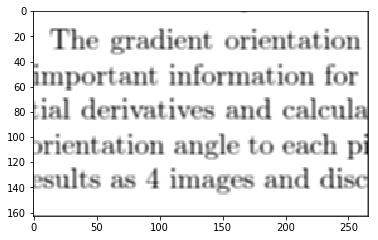

In [19]:
path = "/Users/rakshitsareen/Downloads/images-project2/text.png"
textimg = cv2.imread(path,0)
stextimg = convolve2d(textimg,kernel3X3,3)
plt.imshow(stextimg,cmap='gray')

### Picking of a template from the image. The template taken is the letter 'i' . 

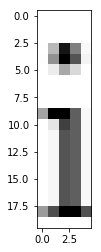

In [20]:
template = textimg[40:60, 0:5]
plt.imshow(template,cmap='gray')

#### Function to calculate the zero mean of a matrix.
##### It takes the mean of the values in the matrix and then subtracts this value from each value, so that the overall mean is 0.

In [21]:
def calculateZeroMeanTemplate(template):
    mean = np.mean(template)
    output = template - mean
    return output

In [22]:
ztemplate = calculateZeroMeanTemplate(template)

##### Plotting of the zero mean template.

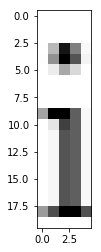

In [23]:
plt.imshow(ztemplate,cmap='gray')

### Function to convolve the template with the image. 
##### This function takes the image and template.
The recipe is to take region of the image equal to the template and convolve with the region. We need to divide the correlation with the sum of the norms of the two images. The output os returned.

In [24]:
def templateMatcher(image, template):
    (row,col) = image.shape
    (tr,tc) = template.shape
    padimg = pad_image = np.pad(image, ((tr,tr),(tc,tc)), 'constant')
    output = np.zeros(image.shape)
            
    for i in range(row):
        for j in range(col):
            
            region = padimg[i:i+tr,j:j+tc]
            region = calculateZeroMeanTemplate(region)

            assert (region.shape == template.shape), 'Dimensional mis-match'
            
            mregion = np.multiply(region, template)                        
            total_magnitude = np.linalg.norm(region) * np.linalg.norm(template)
            
            if (total_magnitude == 0):
                output[i][j] = -1
            else:
                output[i][j] = np.sum(mregion)/total_magnitude
            
    return output
    

#### The output of the correlation of the image with the template.
##### If we notice, we can see highest peaks where the image region exactly matches the template. We will apply thresholding to get the peaks and the position of where the image matched the template.

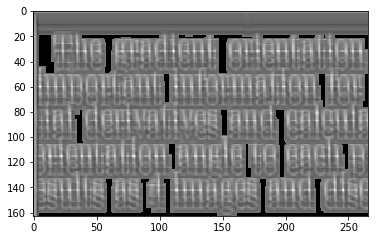

In [25]:
output = templateMatcher(textimg,ztemplate)
plt.imshow(output,cmap='gray')

#### The function to threshold the image. Reduces the value of intensities below the threshold to zero and enhances the ones above to 1 . 

In [26]:
def thresholder(matched_img, val):
    threshold_img = np.copy(matched_img)
    threshold_img[matched_img < val] = 0
    return threshold_img

### Finally the peaks which tells the location of the template in the image.

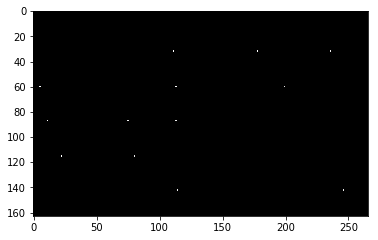

In [27]:
ans = thresholder(output,0.9)
plt.imshow(ans,cmap='gray')

In [28]:
def convolve2dGeneral(image, kernel):
    """
    This function assumes square kernels for now.
    """
    #kernel = np.flipud(np.fliplr(kernel))
    kx = kernel.shape[0]
    ky = kernel.shape[1]
    output = np.zeros_like(image)
    image_padded = np.zeros( (image.shape[0] + kx - 1, image.shape[1] + ky - 1) )
    #print image.shape , image_padded.shape
    skipfactorx = (kx - 1)/2
    skipfactory = (ky - 1)/2
    if skipfactorx == 0:
        skipfactorx += 1
    if skipfactory == 0:
        skipfactory += 1
    image_padded[skipfactorx:-skipfactorx, skipfactory:-skipfactory] = image
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            output[x,y]=(kernel*image_padded[x:x+kx,y:y+ky]).sum()
    return output